In [1]:
import pandas as pd
import numpy as np

* what is the most common Pfam / fold
* which Pfam or fold is most diversely shared/conserved -e.g. prevalent in highest diversity of families, orders etc
* within each family which sets of folds are the most conserved - do core blocks of folds exist only between families or are they shared between multiple families or is there no discrepancy / conservation at all

In [2]:
def annotate_clusters(clu, protein_metadata):
    """
    Annotates protein clusters with metadata from a provided protein metadata DataFrame.

    Parameters:
    ----------
    clu : pd.DataFrame
        DataFrame containing Foldseek easy-cluster output - two columns: 'cluster' and 'members', which represent clustered 
        protein identifiers.
    
    protein_metadata : pd.DataFrame
        DataFrame containing metadata for proteins, including genome accession, phage status, 
        function, pLDDT score, PFAM annotations, and protein length.

    Returns:
    -------
    pd.DataFrame
        Annotated cluster DataFrame where each row represents a pair of cluster-member relationships, 
        enriched with metadata for both the cluster and its members.
    """
    clu.columns = ['cluster', 'members']
    clu['cluster'] = clu['cluster'].str.replace('.pdb', '', regex=True)
    clu['members'] = clu['members'].str.replace('.pdb', '', regex=True)
    
    metadata_cols = ['protein_accn', 'genome_accn', 'phage', 'function', 'pLDDT', 'PFAM1', 
                     'PFAM1_description', 'PFAM1_definition', 'protein_length']
    protein_metadata_cleaned = protein_metadata[metadata_cols].copy()

    # Merge for cluster metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='cluster', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'cluster_genome_accn', 'phage': 'cluster_phage',
                         'function': 'cluster_function', 'pLDDT': 'cluster_pLDDT',
                         'PFAM1': 'cluster_PFAM1', 'PFAM1_description': 'cluster_PFAM1_description',
                         'PFAM1_definition': 'cluster_PFAM1_definition','protein_length':'cluster_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Merge for member metadata
    clu = clu.merge(protein_metadata_cleaned, left_on='members', right_on='protein_accn', how='left') \
        .rename(columns={'genome_accn': 'member_genome_accn', 'phage': 'member_phage',
                         'function': 'member_function', 'pLDDT': 'member_pLDDT',
                         'PFAM1': 'member_PFAM1', 'PFAM1_description': 'member_PFAM1_description',
                         'PFAM1_definition': 'member_PFAM1_definition','protein_length':'member_protein_length'}) \
        .drop(['protein_accn'], axis=1)

    # Comment this out so ALL clusters and proteins are kept
    # Remove self-matches and duplicates
    # clu = clu.drop_duplicates(subset=['cluster', 'members'], keep='first')
    # clu = clu[clu.cluster != clu.members]

    # # Filter out clusters with fewer than 2 members
    # cluster_counts = clu.groupby('cluster')['member_genome_accn'].transform('count')
    # clu = clu[cluster_counts >= 2]

    return clu

In [4]:
df = pd.read_csv('../data/foldseek_easy_cluster/test_thresholds/cov5_c0.4_tm0.3_re1_e1e-2__cluster.tsv',sep='\t',header=None)
metadata = pd.read_csv('../data/protein_metadata.csv')
clu_annot = annotate_clusters(df, metadata)

In [5]:
embeddings = pd.read_csv('../data/embeddings_annotated_expanded.csv', low_memory=False)

In [6]:
embeddings[0:1]

Dim1       Dim2                                         Entry  \
0 -33.523903 -44.496624  AAQ13815.1 hypothetical protein [His2 virus]   

     Pfam1                                            DE1  \
0  PF17367  NiFe-hydrogenase-type-3 Eha complex subunit A   

                                                 CC1 Pfam2  DE2  CC2 Pfam3  \
0  Energy-converting [NiFe] hydrogenases are memb...   NaN  NaN  NaN   NaN   

   ...  CC4 Pfam5  DE5  CC5 Pfam6  DE6  CC6 Pfam7 DE7 CC7  
0  ...  NaN   NaN  NaN  NaN   NaN  NaN  NaN   NaN NaN NaN  

[1 rows x 24 columns]

In [5]:
embeddings['Protein'] = embeddings['Entry'].str.split(' ').str[0]

In [6]:
cluster = clu_annot['cluster'].to_list()
members = clu_annot['members'].to_list()
unique_proteins = set(cluster) | set(members)

In [7]:
embeddings = embeddings[embeddings.Protein.isin(unique_proteins)]

# Create functional categories for Pfams

In [11]:
def classify_pfam(text):
    text = str(text).lower()

    if "hnh" in text and "nuclease" in text:
        return "Mobile_element"

    if "ycf15" in text or "chloroplast" in text:
        return "Other"

    if "dna ligase" in text or "rna ligase" in text or "replicative ligase" in text:
        return "Replication"

    if "ligase" in text:
        return "Metabolism"

    if any(k in text for k in [
        "major capsid", "capsid", "head", "coat", "scaffold", "portal",
        "tail sheath", "tail tube", "neck", "connector", "virion protein",
        "tegument", "fibritin", "gp5", "gp8", "base plate", "surface protein", "gp10",
        "nucleocapsid", "baseplate", "fiber", "envelope", "virion", "collar",
        "head-tail joining", "injectosome", "translocase", "structural"]):
        return "Structure"

    if any(k in text for k in [
        "terminase", "dna packaging", "packaging motor", "gp17",
        "herpesvirus processing", "herpesvirus transport"]):
        return "Packaging"

    if any(k in text for k in [
        "polymerase", "helicase", "primase", "replisome", "topoisomerase",
        "gyrase", "proofreading", "ribonucleotide reductase", "mcm",
        "reverse transcriptase", "transcriptional activator", "transcription factor"]):
        return "Replication"

    if any(k in text for k in [
        "ligase"]) and "biotin" not in text:  # PF03744 is a ligase but metabolic
        return "Replication"

    if any(k in text for k in [
        "endonuclease", "exonuclease", "nuclease"]) and "hnh" not in text:
        return "Replication"

    if any(k in text for k in [
        "holin", "endolysin", "lysin", "spanin", "cell wall degradation",
        "lysis", "muramidase", "rdd", "lysozyme"]):
        return "Lysis"

    if any(k in text for k in [
        "tail fiber", "tailspike", "rbp", "receptor", "adhesin", "adhesion",
        "host specificity", "tropism", "spike", "gp19", "gp12", "gp37", "gp38", "virulence"]):
        return "Infection"

    if any(k in text for k in [
        "integrase", "recombinase", "transposase", "transposon", "resolvase",
        "insertion sequence", "is element", "mu", "serine recombinase",
        "tyrosine recombinase", "giy-yig", "recA", "recT"]):
        return "Mobile_element"

    if any(k in text for k in [
        "toxin", "antitoxin", "toxin-antitoxin", "abortive infection", "abi",
        "restriction-modification", "ocr", "dna mimic", "immunity", "crispr",
        "anti-restriction"]):
        return "Defense"

    if any(k in text for k in [
        "channel", "porin", "transport", "permease", "symporter", "antiporter",
        "abc transporter"]):
        return "Transport"

    if any(k in text for k in [
        "kinase", "phosphatase", "oxidase", "dehydrogenase", "isomerase",
        "hydrolase", "enzyme", "transferase", "ligase", "metabolism", "biosynthesis", "synthetase", "bioW", "coA"]):
        return "Metabolism"

    if any(k in text for k in [
        "repressor", "activator", "regulator", "zinc finger", "helix-turn-helix",
        "ht-h", "sant", "marr", "sam-like", "ribbon-helix-helix"]):
        return "Regulation"

    if any(k in text for k in [
        "sensor", "response regulator", "histidine kinase", "quorum sensing",
        "chemotaxis", "two-component", "signal transduction"]):
        return "Signaling"

    if any(k in text for k in [
        "ribosome", "ribosomal", "translation", "elongation factor", "initiation factor", "termination factor"]):
        return "Translation"

    if any(k in text for k in [
        "immune evasion", "vif", "tat", "modulator", "interferon", "bcl",
        "host interaction", "virulence factor"]):
        return "Host_modulation"

    if any(k in text for k in [
        "hypothetical", "unknown", "uncharacterised", "uncharacterized", "duf", "upf",
        "domain of unknown function", "family of unknown function"]):
        return "Unknown"

    return "Other"

In [12]:
embeddings['Function'] = embeddings['DE1'].apply(classify_pfam)

In [13]:
embeddings[0:1]

Dim1       Dim2                                              Entry  \
795 -0.528396 -23.986313  DBA35445.1 TPA_asm: hypothetical protein vir08...   

       Pfam1                                     DE1  \
795  PF01893  Uncharacterised protein family UPF0058   

                                                   CC1 Pfam2  DE2  CC2 Pfam3  \
795  This archaebacterial protein has no known func...   NaN  NaN  NaN   NaN   

     ...  DE5  CC5 Pfam6  DE6  CC6 Pfam7 DE7 CC7     Protein Function  
795  ...  NaN  NaN   NaN  NaN  NaN   NaN NaN NaN  DBA35445.1  Unknown  

[1 rows x 26 columns]

In [12]:
Pfam_function_counts = embeddings.groupby('Function')['Pfam1'].count().reset_index().sort_values(by='Pfam1')

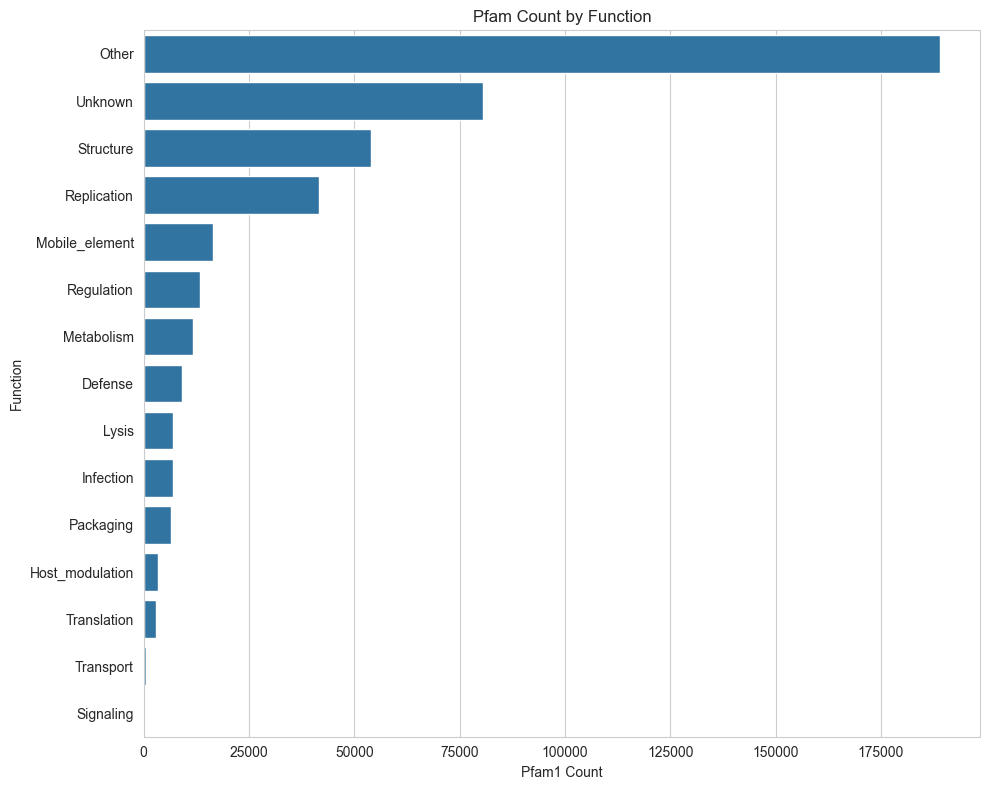

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Sort values if you like
Pfam_function_counts = Pfam_function_counts.sort_values("Pfam1", ascending=False)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(data=Pfam_function_counts, y="Function", x="Pfam1")
plt.xlabel("Pfam1 Count")
plt.ylabel("Function")
plt.title("Pfam Count by Function")
plt.tight_layout()
plt.show()

C:\Users\crtuser\AppData\Local\Temp\ipykernel_1692\2977611723.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pfam_counts, y="PFAM_DE1", x="Count", palette="viridis")


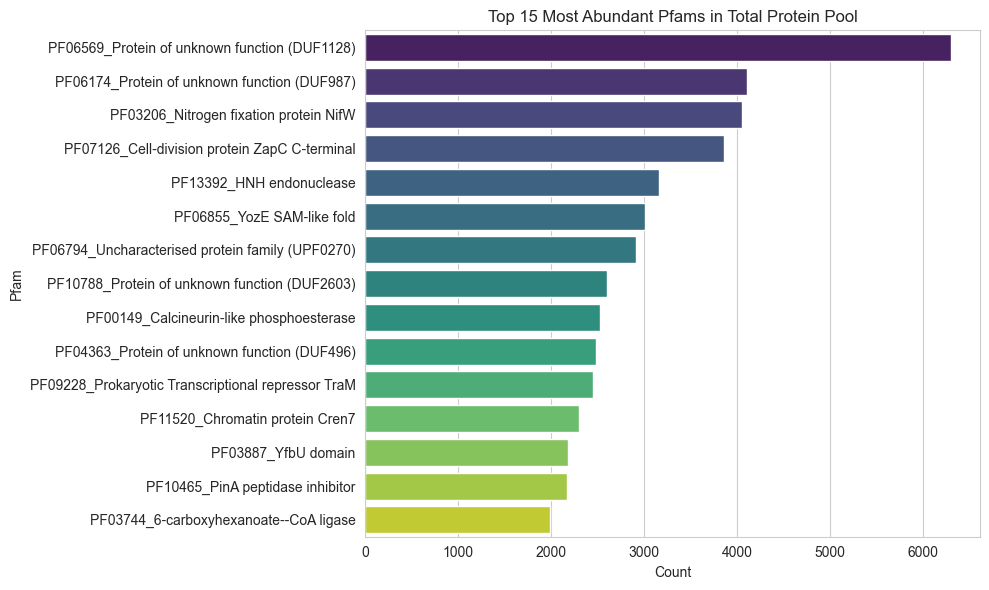

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count Pfam1 occurrences and take the top 15
embeddings['PFAM_DE1'] = embeddings['Pfam1'].astype(str) + "_" + embeddings['DE1'].astype(str)
top_pfam_counts = embeddings['PFAM_DE1'].value_counts().head(15).reset_index()
top_pfam_counts.columns = ['PFAM_DE1', 'Count']

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.barplot(data=top_pfam_counts, y="PFAM_DE1", x="Count", palette="viridis")

plt.title("Top 15 Most Abundant Pfams in Total Protein Pool")
plt.xlabel("Count")
plt.ylabel("Pfam")
plt.tight_layout()
plt.show()

In [ ]:
Protein representatives from each protein of unknown function category was selected and structures searched on foldseek server

XHH73151.1,NP_049721.1 - DUF1128
NP_049622.1 - DUF987 - Lipoprotein
NP_049643.1 - DUF2603 - ERF superfamily protein - AP2/ERF-like DNA-binding domain -> transcriptional regulation
NP_039703.1 - DUF496 - SPOR domain-containing protein

In [64]:
embeddings['PFAM_DE1'] = embeddings['Pfam1'].astype(str) + "_" + embeddings['DE1'].astype(str)

In [76]:
embeddings.Function.unique()

array(['Unknown', 'Other', 'Infection', 'Replication', 'Structure',
       'Defense', 'Lysis', 'Translation', 'Regulation', 'Mobile_element',
       'Host_modulation', 'Packaging', 'Metabolism', 'Signaling',
       'Transport'], dtype=object)

In [16]:
Structure = embeddings[embeddings.Function == 'Structure']
Replication = embeddings[embeddings.Function == 'Replication']
Regulation = embeddings[embeddings.Function == 'Regulation']
Metabolism = embeddings[embeddings.Function == 'Metabolism']
Defense = embeddings[embeddings.Function == 'Defense']
Lysis = embeddings[embeddings.Function == 'Lysis']
Metabolism = embeddings[embeddings.Function == 'Metabolism']
Mobile_element = embeddings[embeddings.Function == 'Mobile_element']
Host_modulation = embeddings[embeddings.Function == 'Host_modulation']
Infection = embeddings[embeddings.Function == 'Infection']
Transport = embeddings[embeddings.Function == 'Transport']
Signaling = embeddings[embeddings.Function == 'Signaling']

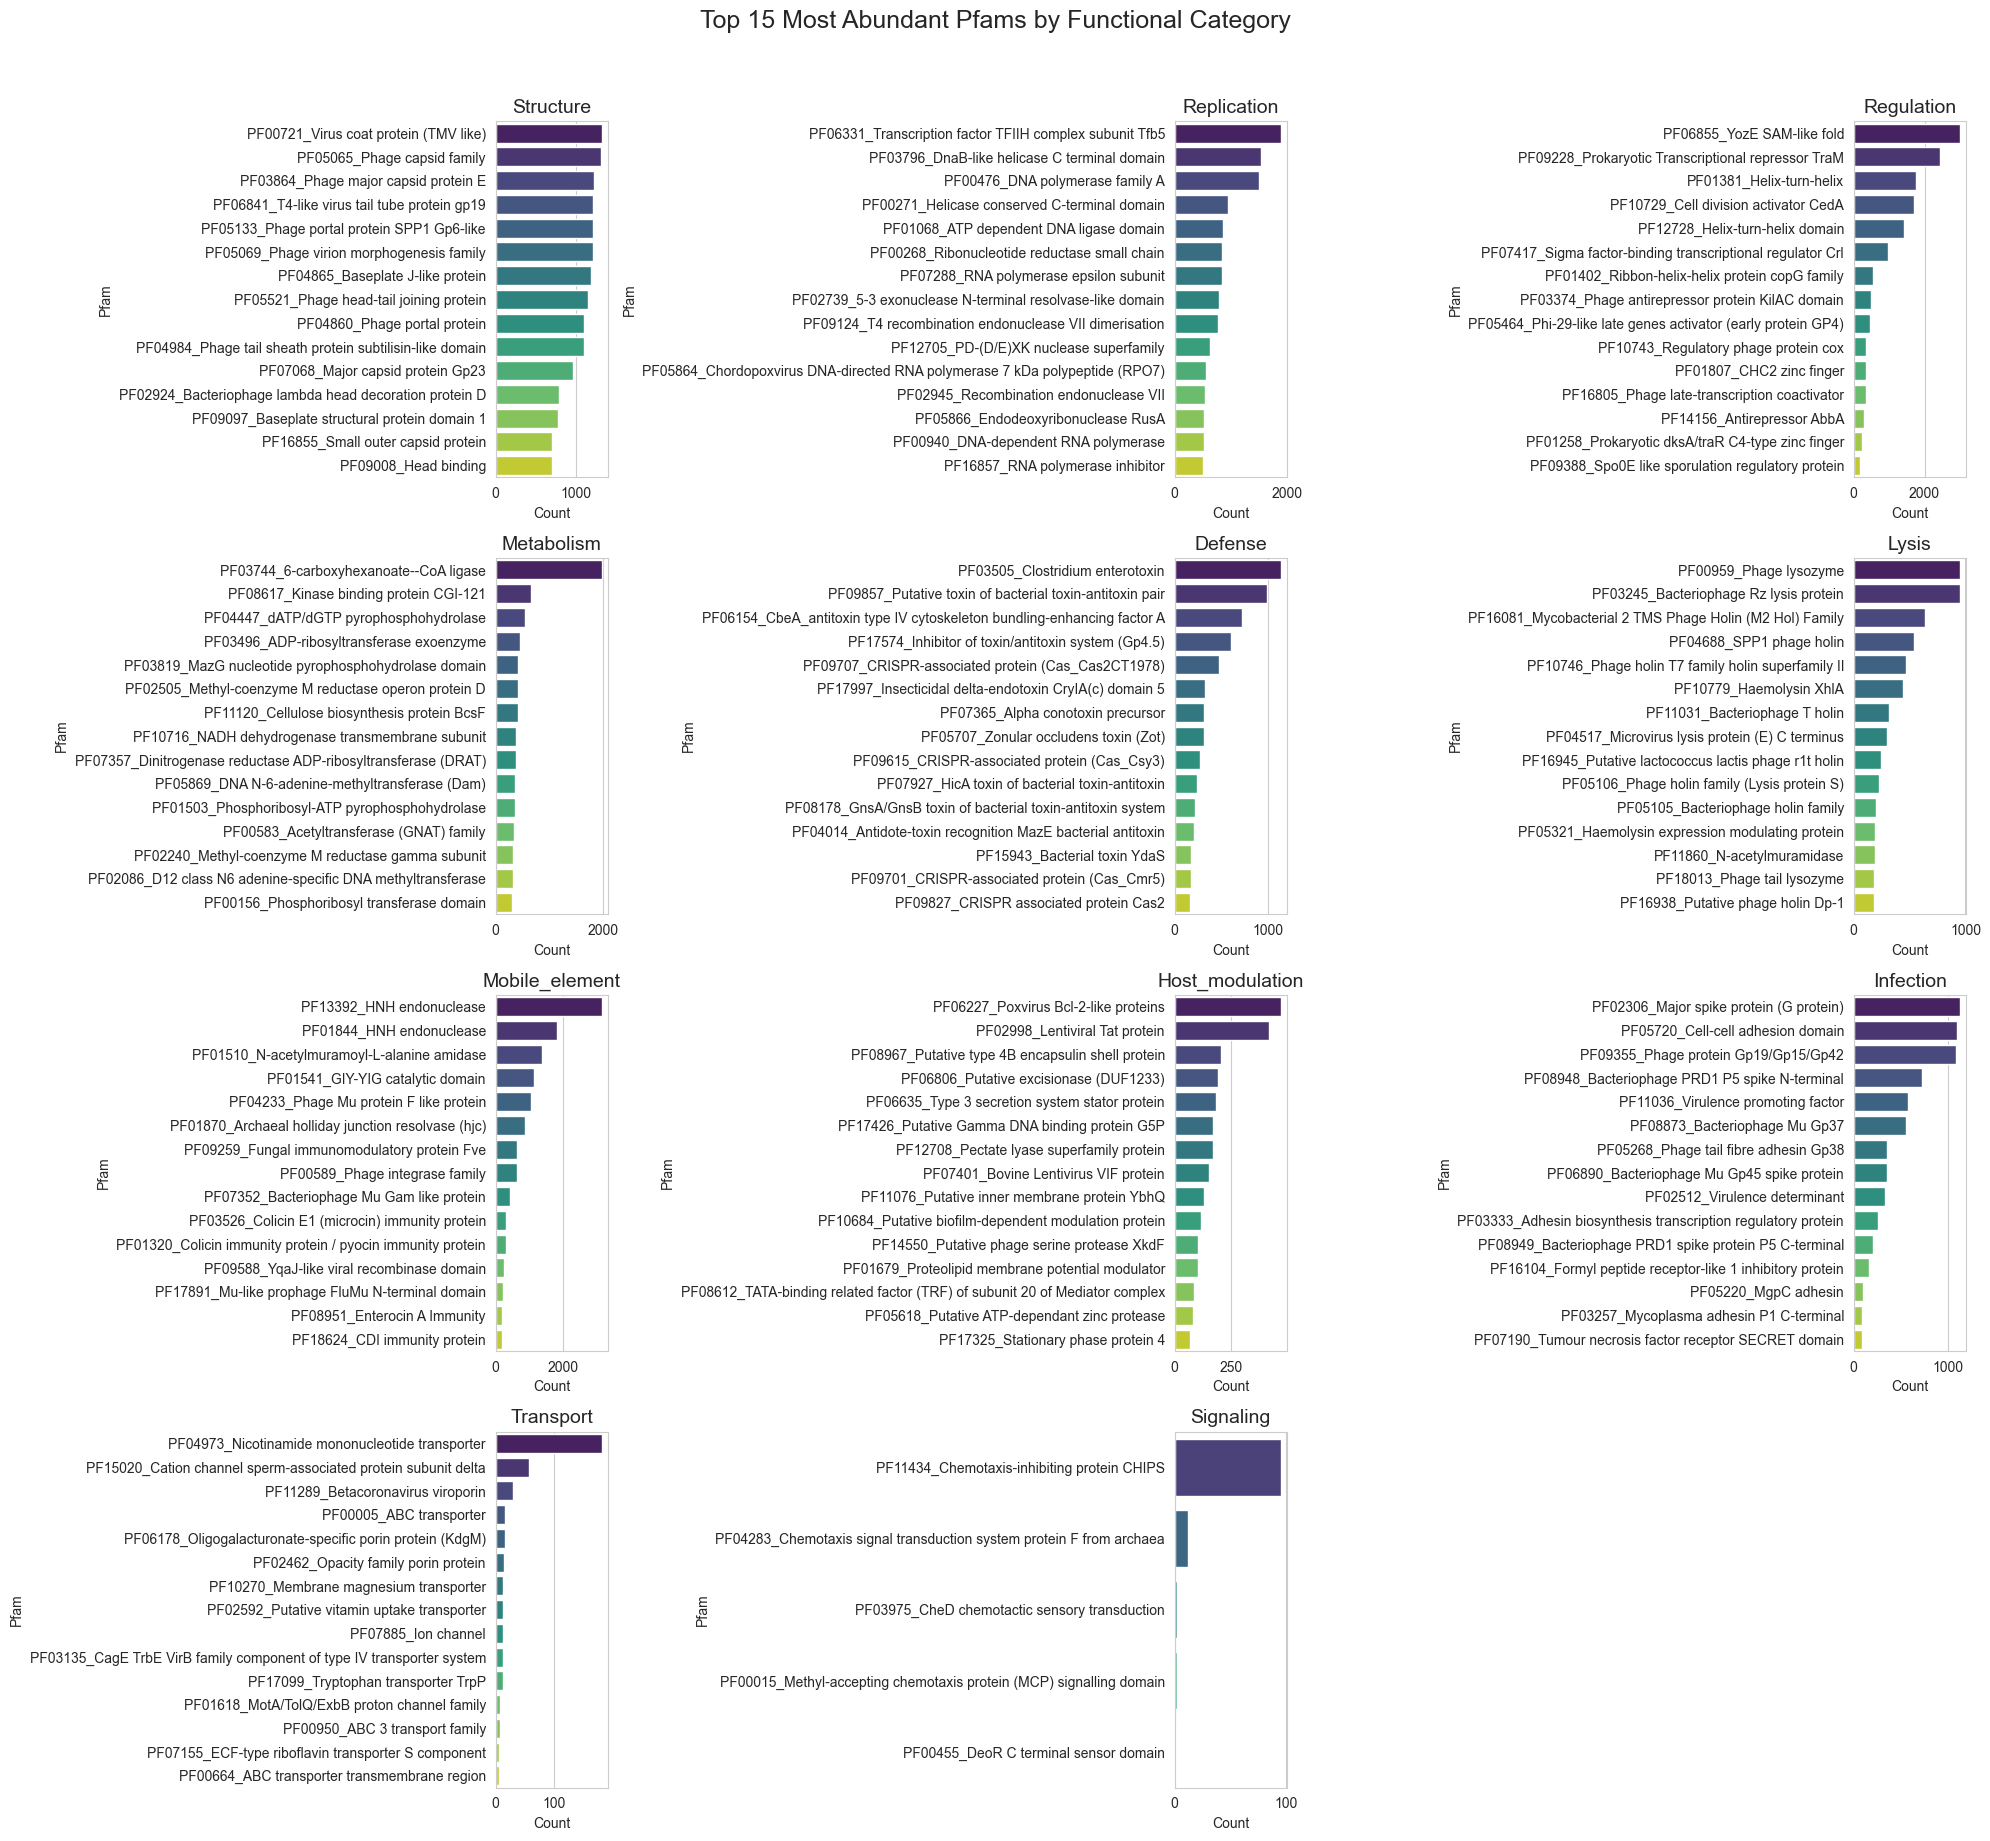

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define all 12 function subsets
function_dfs = {
    "Structure": Structure,
    "Replication": Replication,
    "Regulation": Regulation,
    "Metabolism": Metabolism,
    "Defense": Defense,
    "Lysis": Lysis,
    "Mobile_element": Mobile_element,
    "Host_modulation": Host_modulation,
    "Infection": Infection,
    "Transport": Transport,
    "Signaling": Signaling,
}

# Plot setup
sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
axes = axes.flatten()

for i, (func_name, df) in enumerate(function_dfs.items()):
    top_pfam_counts = df['PFAM_DE1'].value_counts().head(15).reset_index()
    top_pfam_counts.columns = ['PFAM_DE1', 'Count']

    sns.barplot(
        data=top_pfam_counts,
        y="PFAM_DE1",
        x="Count",
        ax=axes[i],
        hue="PFAM_DE1",
        palette="viridis",
        legend=False
    )
    axes[i].set_title(f"{func_name}", fontsize=14)
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("Pfam")

# Remove any unused subplots (if len < 12)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 15 Most Abundant Pfams by Functional Category", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [17]:
filtered = embeddings[~embeddings['Function'].isin(['Unknown', 'Other'])]

In [18]:
filtered_test = filtered[(filtered.Function=='Replication') | (filtered.Function=='Structure')]

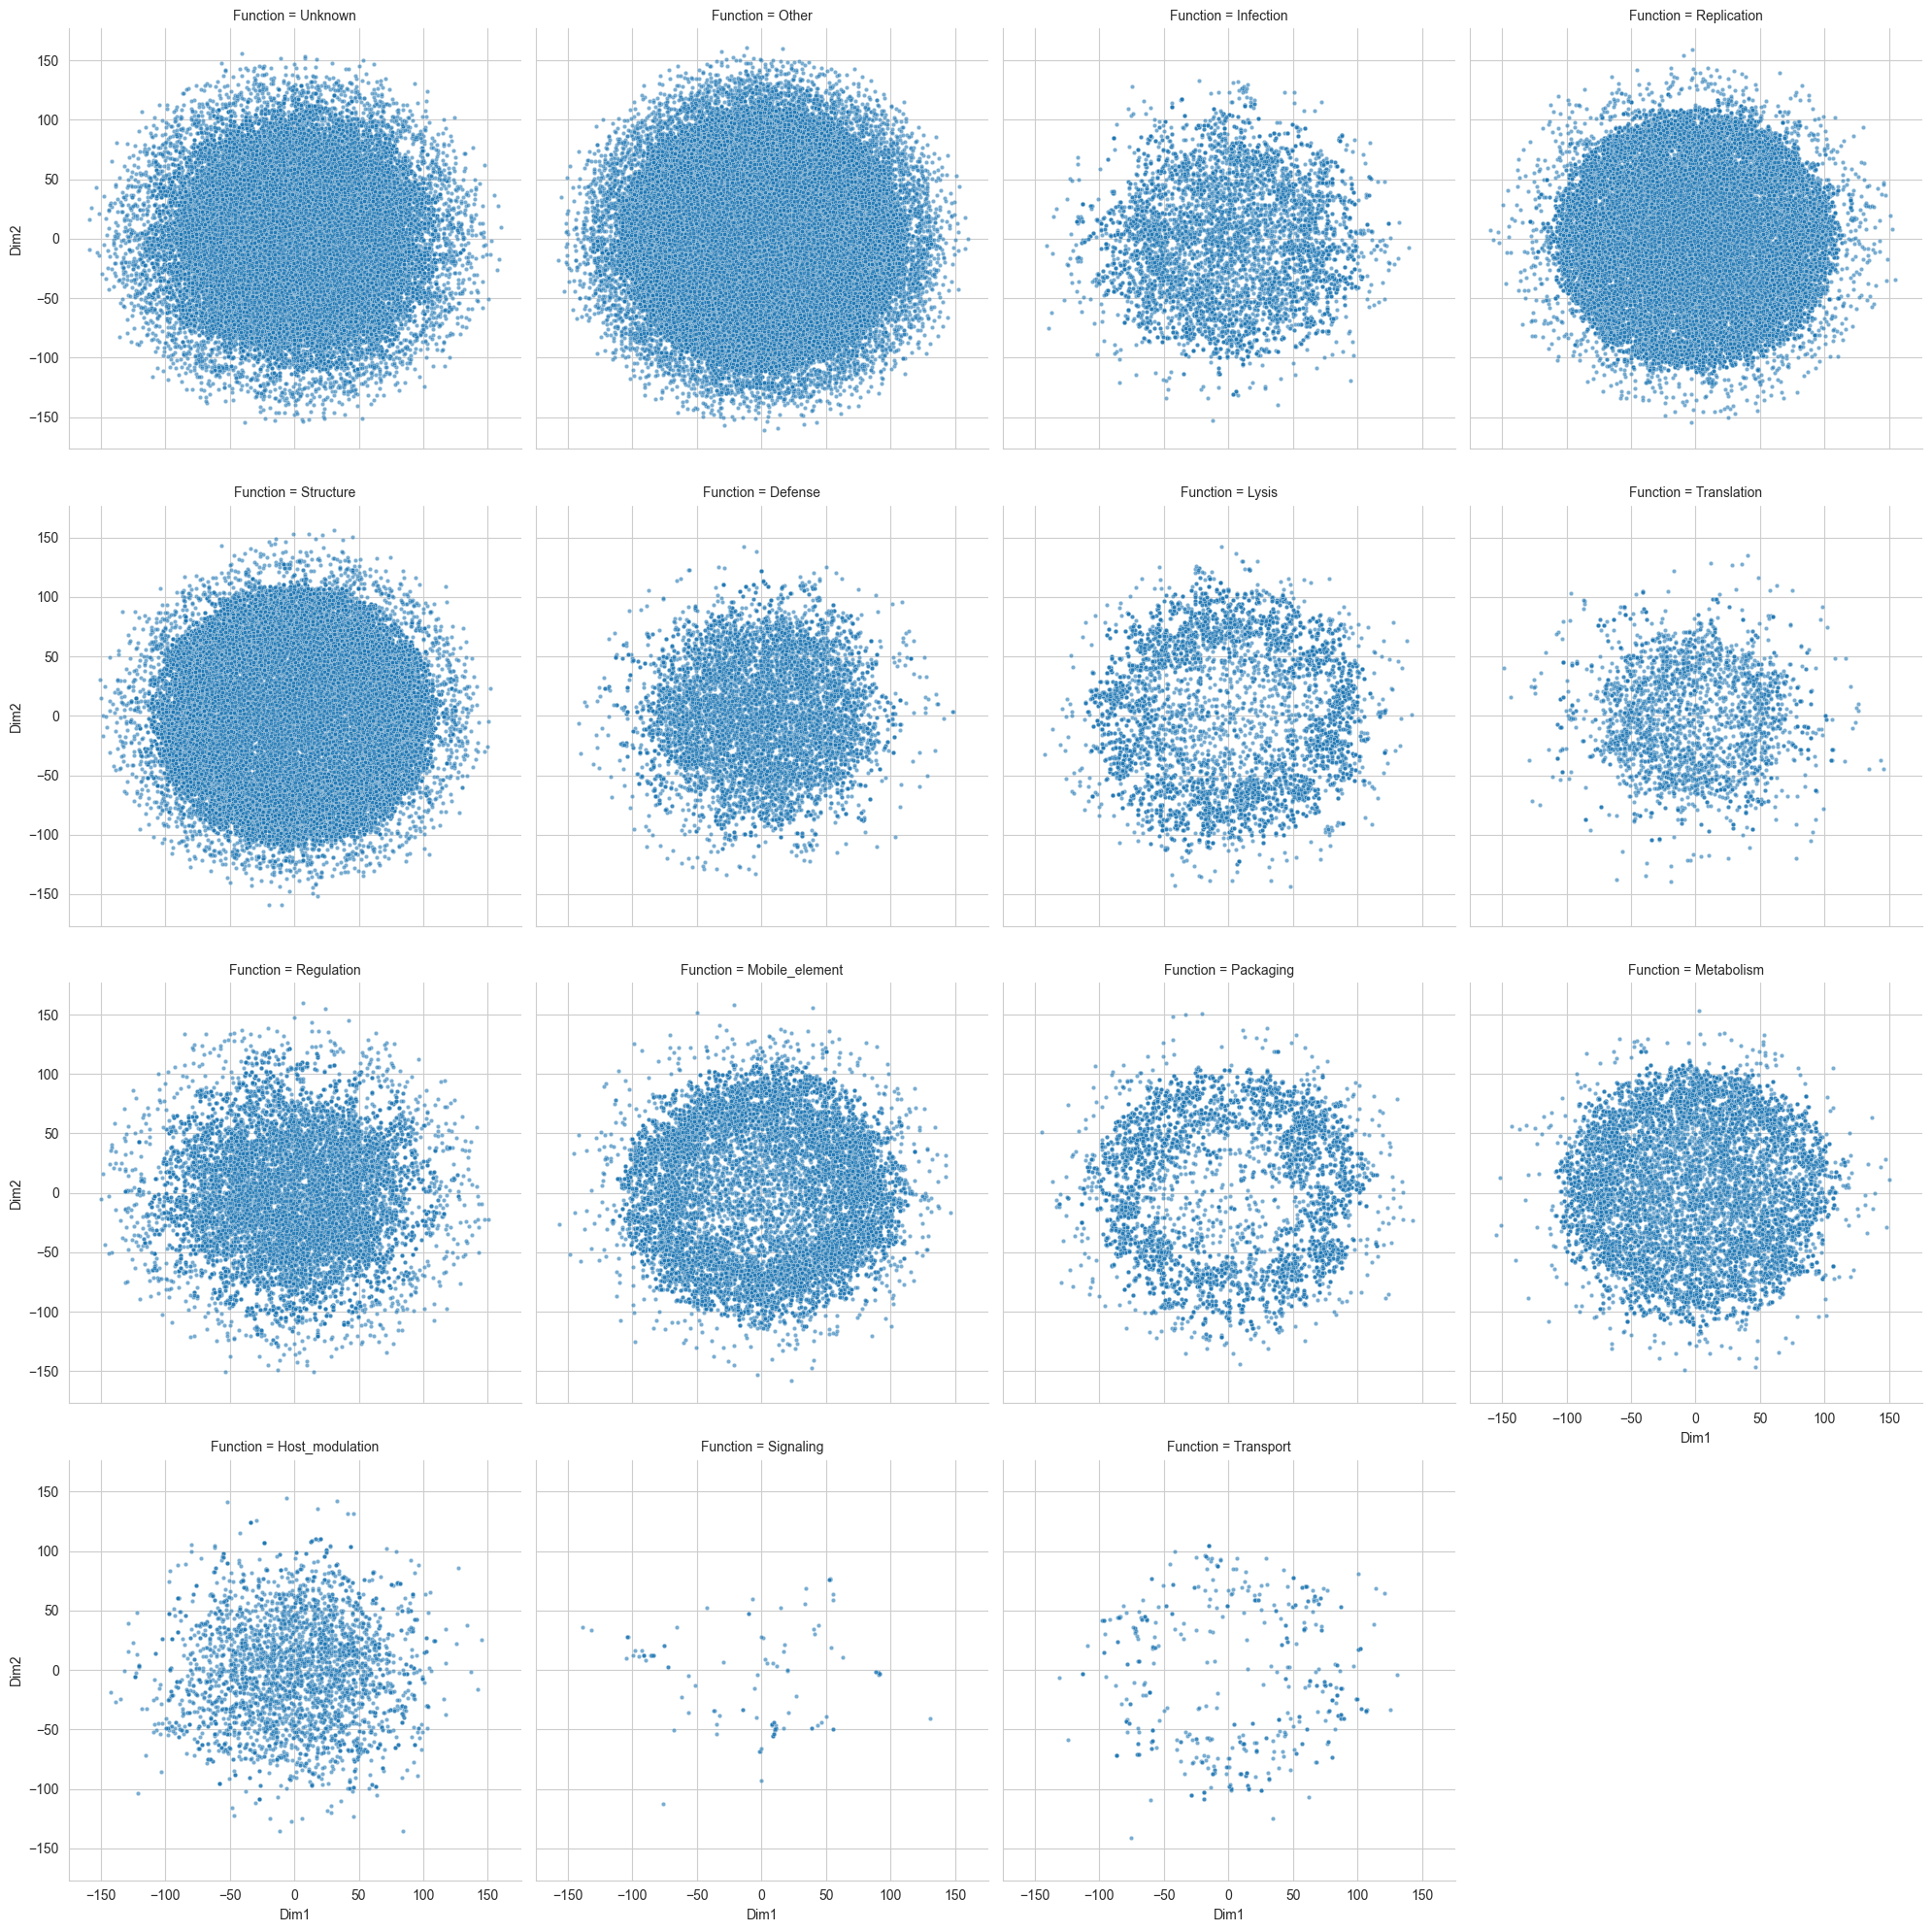

In [19]:
# ok nothing really emerging here lol
sns.relplot(data=embeddings, x="Dim1", y="Dim2", col="Function", col_wrap=4, s=10, alpha=0.6)

# Merge embeddings on metadata to get taxonomy..

In [18]:
protein_metadata = pd.read_csv('../data/protein_metadata.csv')
embeddings_extra = embeddings.merge(protein_metadata,left_on='Protein',right_on='protein_accn',how='left')
ictv_metadata = pd.read_csv('../data/4083_ICTV_metadata.csv')
embeddings_taxa = embeddings_extra.merge(ictv_metadata, left_on='genome_accn', right_on='genome_accn')
df = embeddings_taxa

In [19]:
df['Order'] = df['Order'].fillna('Unclassified_Order')

In [20]:
df.to_csv('../data/embeddings_PFAMS_easy_cluster.csv',index=False)

In [55]:
host_mod = df[df.Function=='Host_modulation']

In [58]:
host_mod.columns

Index(['Dim1', 'Dim2', 'Entry', 'Pfam1', 'DE1', 'CC1', 'Pfam2', 'DE2', 'CC2',
       'Pfam3', 'DE3', 'CC3', 'Pfam4', 'DE4', 'CC4', 'Pfam5', 'DE5', 'CC5',
       'Pfam6', 'DE6', 'CC6', 'Pfam7', 'DE7', 'CC7', 'Protein', 'Function',
       'PFAM_DE1', 'genome_accn', 'protein_accn', 'phage', 'function',
       'protein', 'pLDDT', 'PFAM1', 'PFAM1_description', 'PFAM1_definition',
       'protein_id', 'protein_length', 'Sort', 'Isolate Sort', 'Realm',
       'Subrealm', 'Kingdom', 'Subkingdom', 'Phylum', 'Subphylum', 'Class',
       'Subclass', 'Order', 'Suborder', 'Family', 'Subfamily', 'Genus',
       'Subgenus', 'Species', 'Exemplar or additional isolate',
       'Virus name(s)', 'Virus name abbreviation(s)',
       'Virus isolate designation', 'Virus GENBANK accession',
       'Virus REFSEQ accession', 'Genome coverage', 'Genome composition',
       'Host source', 'Exemplar GenBank Accession Number',
       'Exemplar virus name', 'Exemplar isolate designation', 'Host/Source',
       'Cha

In [61]:
host_mod.groupby(['Pfam1','DE1'])['genome_accn']\
            .count()\
            .reset_index()\
            .sort_values(by='genome_accn')

Pfam1                                                DE1  genome_accn
25  PF04194  Programmed cell death protein 2 C-terminal put...            1
55  PF12044                          Putative peptidase family            1
56  PF12201      Bcl2-interacting killer BH3-domain containing            1
41  PF08421                       Putative zinc binding domain            1
59  PF13933                          Putative peptidase family            1
..      ...                                                ...          ...
36  PF06806                     Putative excisionase (DUF1233)          193
43  PF08967          Putative type 4B encapsulin shell protein          207
19  PF02998                             Lentiviral Tat protein          416
32  PF06227                       Poxvirus Bcl-2-like proteins          472
48  PF10705       Chloroplast protein precursor Ycf15 putative         1958

[72 rows x 3 columns]

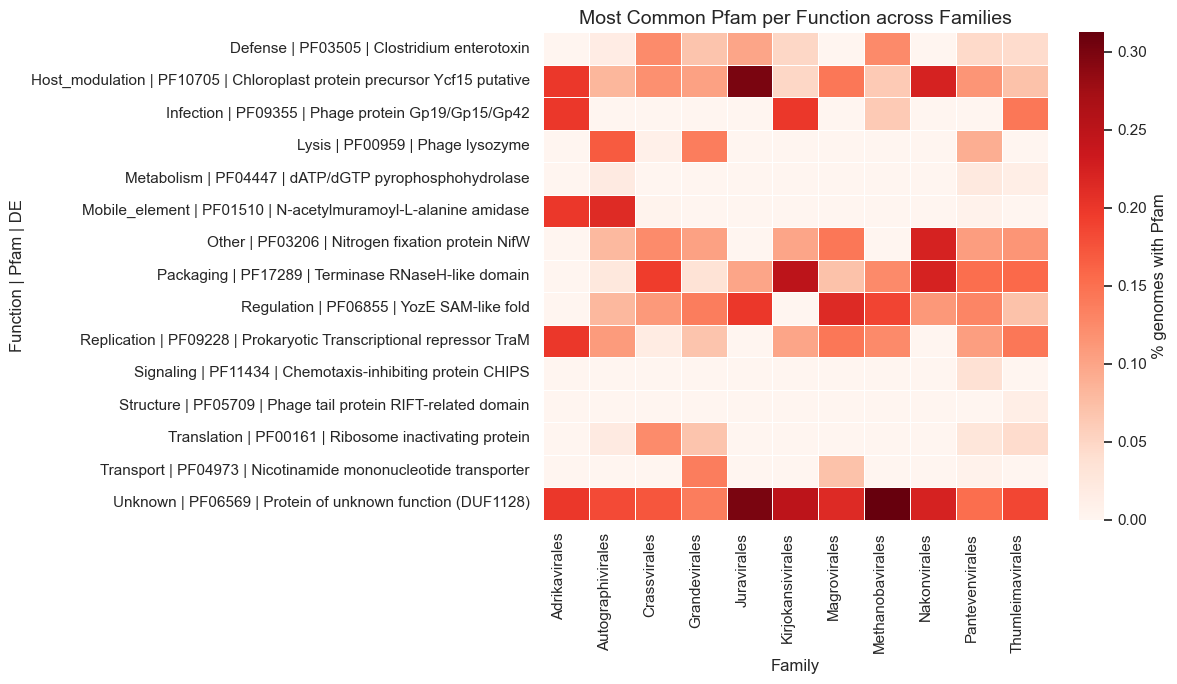

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Pick top Pfam per Function (most common across all genomes)
top_pfam_per_function = (
    df.groupby(['Function', 'Pfam1'])['genome_accn']
    .nunique()
    .reset_index()
    .sort_values(['Function', 'genome_accn'], ascending=[True, False])
    .drop_duplicates('Function')
)

# 2. Get just the Pfams
selected_pfams = top_pfam_per_function['Pfam1'].tolist()

# 3. Create presence matrix and filter to those Pfams
pfam_matrix = df.groupby(['Order', 'Pfam1'])['genome_accn'].nunique().unstack(fill_value=0)
pfam_matrix = pfam_matrix[selected_pfams]

# 4. Normalize per family (row-wise % presence)
pfam_norm = pfam_matrix.div(pfam_matrix.sum(axis=1), axis=0)

# 5. Create descriptive y-axis labels: "Function | Pfam | DE"
pfam_descriptions = df.drop_duplicates('Pfam1').set_index('Pfam1')['DE1']
top_pfam_per_function['label'] = (
    top_pfam_per_function['Function'] + " | " +
    top_pfam_per_function['Pfam1'] + " | " +
    top_pfam_per_function['Pfam1'].map(pfam_descriptions).fillna("Unknown")
)

# 6. Rename columns to descriptive labels
label_mapping = dict(zip(top_pfam_per_function['Pfam1'], top_pfam_per_function['label']))
pfam_norm = pfam_norm.rename(columns=label_mapping)

# 7. Transpose for rotated plot
pfam_norm_T = pfam_norm.transpose()

# 8. Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pfam_norm_T, cmap="Reds", cbar_kws={"label": "% genomes with Pfam"}, linewidths=0.5)

# Format axes
plt.title("Most Common Pfam per Function across Families", fontsize=14)
plt.xlabel("Family")
plt.ylabel("Function | Pfam | DE")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


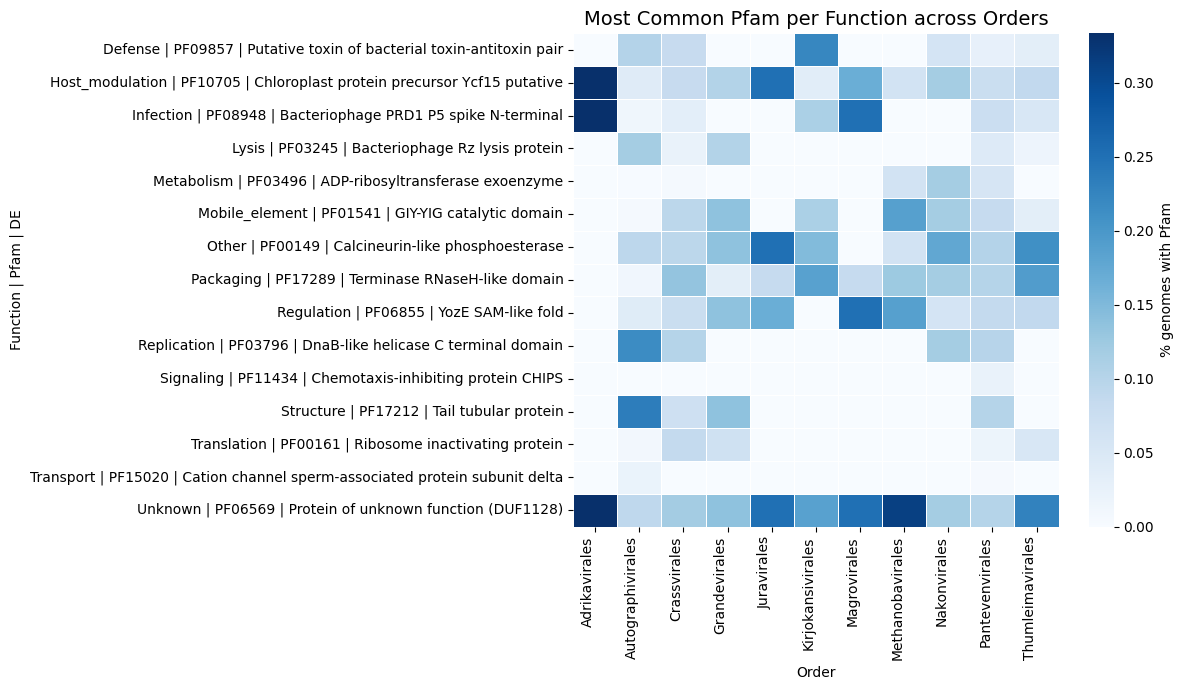

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Pick top Pfam per Function (most common across all genomes)
top_pfam_per_function = (
    df.groupby(['Function', 'Pfam1'])['genome_accn']
    .nunique()
    .reset_index()
    .sort_values(['Function', 'genome_accn'], ascending=[True, False])
    .drop_duplicates('Function')
)

# 2. Get just the Pfams
selected_pfams = top_pfam_per_function['Pfam1'].tolist()

# 3. Create presence matrix and filter to those Pfams
pfam_matrix = df.groupby(['Order', 'Pfam1'])['genome_accn'].nunique().unstack(fill_value=0)
pfam_matrix = pfam_matrix[selected_pfams]

# 4. Normalize per family (row-wise % presence)
pfam_norm = pfam_matrix.div(pfam_matrix.sum(axis=1), axis=0)

# 5. Create descriptive y-axis labels: "Function | Pfam | DE"
pfam_descriptions = df.drop_duplicates('Pfam1').set_index('Pfam1')['DE1']
top_pfam_per_function['label'] = (
    top_pfam_per_function['Function'] + " | " +
    top_pfam_per_function['Pfam1'] + " | " +
    top_pfam_per_function['Pfam1'].map(pfam_descriptions).fillna("Unknown")
)

# 6. Rename columns to descriptive labels
label_mapping = dict(zip(top_pfam_per_function['Pfam1'], top_pfam_per_function['label']))
pfam_norm = pfam_norm.rename(columns=label_mapping)

# 7. Transpose for rotated plot
pfam_norm_T = pfam_norm.transpose()

# 8. Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(pfam_norm_T, cmap="Blues", cbar_kws={"label": "% genomes with Pfam"}, linewidths=0.5)

# Format axes
plt.title("Most Common Pfam per Function across Orders", fontsize=14)
plt.xlabel("Order")
plt.ylabel("Function | Pfam | DE")
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Attempting network analysis

In [22]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.lines as mlines


def plot_core_pfam_network_collapsed(df, rank='Order', threshold=0.8, highlight_rank=None):
    """
    Plots a collapsed bipartite network of core Pfams (present in >= threshold of genomes) by a taxonomic rank.

    Parameters:
        df (pd.DataFrame): Must contain 'Pfam', 'Function', 'genome_accn', and the specified rank column.
        rank (str): Taxonomic rank to collapse on (e.g. 'Order', 'Family').
        threshold (float): Fraction cutoff to define "core" Pfams within a rank group.
        highlight_rank (str or list): Optional. Specific rank(s) to enlarge.
    """
    # Step 1: Compute core Pfams
    rank_totals = df[[rank, 'genome_accn']].drop_duplicates().groupby(rank).size()
    pfam_counts = df.groupby([rank, 'Pfam1'])['genome_accn'].nunique()
    pfam_frac = (pfam_counts / rank_totals).reset_index()
    pfam_frac.columns = [rank, 'Pfam1', 'Fraction']
    core_pfams = pfam_frac[pfam_frac['Fraction'] >= threshold]['Pfam1'].unique()

    # Step 2: Subset and exclude Unknown/Other functions
    pfam_functions = df[['Pfam1', 'Function']].drop_duplicates().set_index('Pfam1')['Function'].to_dict()
    valid_pfams = [pfam for pfam in core_pfams if pfam_functions.get(pfam) not in ['Unknown', 'Other']]
    core_df = df[df['Pfam1'].isin(valid_pfams)]

    # Step 3: Build graph
    B = nx.Graph()

    # Rank nodes
    for r in core_df[[rank]].drop_duplicates()[rank]:
        B.add_node(r, type='rank')

    # Pfam nodes
    for pfam in valid_pfams:dd
        B.add_node(pfam, type='pfam', function=pfam_functions.get(pfam, 'Unknown'))

    # Edges between rank and Pfam if at least one genome in that rank has it
    edges = core_df[[rank, 'Pfam1']].drop_duplicates().values.tolist()
    B.add_edges_from(edges)

    # Layout
    pos = nx.spring_layout(B, seed=42)

    # Split node types
    rank_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'rank']
    pfam_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'pfam']

    # Colors
    colors = plt.cm.tab20.colors
    color_cycle = cycle(colors)
    rank_palette = {r: next(color_cycle) for r in rank_nodes}
    function_palette = {
        'Structure': 'red', 'Replication': 'blue', 'Packaging': 'green', 'Lysis': 'orange',
        'Defense': 'purple', 'Transport': 'cyan', 'Signaling': 'yellow', 'Regulation': 'pink',
        'Infection': 'brown', 'Host_modulation': 'magenta', 'Mobile_element': 'lime'
    }

    rank_colors = [rank_palette[n] for n in rank_nodes]
    pfam_colors = [function_palette.get(B.nodes[n]['function'], 'gray') for n in pfam_nodes]

    # Optional: scale up a specific rank
    if highlight_rank:
        if isinstance(highlight_rank, str):
            highlight_rank = [highlight_rank]
        rank_sizes = [1000 if n in highlight_rank else 500 for n in rank_nodes]
    else:
        rank_sizes = 500

    # Plot
    plt.figure(figsize=(18, 14))

    nx.draw_networkx_nodes(B, pos, nodelist=rank_nodes, node_color=rank_colors,
                           node_shape='s', node_size=rank_sizes, label='Taxonomic group')
    nx.draw_networkx_nodes(B, pos, nodelist=pfam_nodes, node_color=pfam_colors,
                           node_shape='o', node_size=100, label='Pfam')
    nx.draw_networkx_edges(B, pos, alpha=0.2)

    # Legend
    rank_handles = [
        mlines.Line2D([], [], color=color, marker='s', linestyle='None', markersize=8, label=r)
        for r, color in rank_palette.items()
    ]
    function_handles = [
        mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=8, label=func)
        for func, color in function_palette.items()
    ]

    legend1 = plt.legend(handles=rank_handles, title=f"{rank} (squares)", bbox_to_anchor=(1.05, 1), loc='upper left')
    legend2 = plt.legend(handles=function_handles, title="Pfam Function (circles)", bbox_to_anchor=(1.05, 0.5), loc='upper left')
    plt.gca().add_artist(legend1)

    plt.title(f"Core Pfam Network by {rank} (≥{int(threshold * 100)}% genomes)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [28]:
df = df.dropna(subset='Order')

In [36]:
import matplotlib.pyplot as plt

def plot_core_pfam_network_collapsed_ax(df, ax, rank='Order', threshold=0.8, highlight_rank=None):
    """
    Same as plot_core_pfam_network_collapsed but plots into a given matplotlib Axes `ax`.
    """
    import networkx as nx
    from itertools import cycle

    # Step 1: Compute core Pfams
    rank_totals = df[[rank, 'genome_accn']].drop_duplicates().groupby(rank).size()
    pfam_counts = df.groupby([rank, 'Pfam1'])['genome_accn'].nunique()
    pfam_frac = (pfam_counts / rank_totals).reset_index()
    pfam_frac.columns = [rank, 'Pfam1', 'Fraction']
    core_pfams = pfam_frac[pfam_frac['Fraction'] >= threshold]['Pfam1'].unique()

    # Step 2: Subset and exclude Unknown/Other functions
    pfam_functions = df[['Pfam1', 'Function']].drop_duplicates().set_index('Pfam1')['Function'].to_dict()
    valid_pfams = [pfam for pfam in core_pfams if pfam_functions.get(pfam) not in ['Unknown', 'Other']]
    core_df = df[df['Pfam1'].isin(valid_pfams)]

    # Step 3: Build graph
    B = nx.Graph()

    # Rank nodes
    for r in core_df[[rank]].drop_duplicates()[rank]:
        B.add_node(r, type='rank')

    # Pfam nodes
    for pfam in valid_pfams:
        B.add_node(pfam, type='pfam', function=pfam_functions.get(pfam, 'Unknown'))

    # Edges between rank and Pfam if at least one genome in that rank has it
    edges = core_df[[rank, 'Pfam1']].drop_duplicates().values.tolist()
    B.add_edges_from(edges)

    # Layout
    pos = nx.spring_layout(B, seed=42)

    # Split node types
    rank_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'rank']
    pfam_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'pfam']

    # Colors
    colors = plt.cm.tab20.colors
    color_cycle = cycle(colors)
    rank_palette = {r: next(color_cycle) for r in rank_nodes}
    function_palette = {
        'Structure': 'red', 'Replication': 'blue', 'Packaging': 'green', 'Lysis': 'orange',
        'Defense': 'purple', 'Transport': 'cyan', 'Signaling': 'yellow', 'Regulation': 'pink',
        'Infection': 'brown', 'Host_modulation': 'magenta', 'Mobile_element': 'lime'
    }

    rank_colors = [rank_palette[n] for n in rank_nodes]
    pfam_colors = [function_palette.get(B.nodes[n]['function'], 'gray') for n in pfam_nodes]

    # Optional: scale up a specific rank
    if highlight_rank:
        if isinstance(highlight_rank, str):
            highlight_rank = [highlight_rank]
        rank_sizes = [1000 if n in highlight_rank else 300 for n in rank_nodes]
    else:
        rank_sizes = 300

    # Draw on given axis
    nx.draw_networkx_nodes(B, pos, nodelist=rank_nodes, node_color=rank_colors,
                           node_shape='s', node_size=rank_sizes, ax=ax)
    nx.draw_networkx_nodes(B, pos, nodelist=pfam_nodes, node_color=pfam_colors,
                           node_shape='o', node_size=80, ax=ax)
    nx.draw_networkx_edges(B, pos, alpha=0.15, edge_color='gray', width=0.5, ax=ax)

    ax.set_title(f"{highlight_rank[0] if highlight_rank else ''}", fontsize=10)
    ax.axis('off')

def plot_core_pfam_network_panel(df, rank='Order', threshold=0.9, ncols=4):
    """
    Plots a multi-panel grid of core Pfam networks, one per rank group.
    """
    unique_ranks = sorted(df[rank].dropna().unique())
    n = len(unique_ranks)
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, r in enumerate(unique_ranks):
        plot_core_pfam_network_collapsed_ax(df, ax=axes[i], rank=rank, threshold=threshold, highlight_rank=r)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"Core Pfam Network by {rank} (≥{int(threshold * 100)}% genomes)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


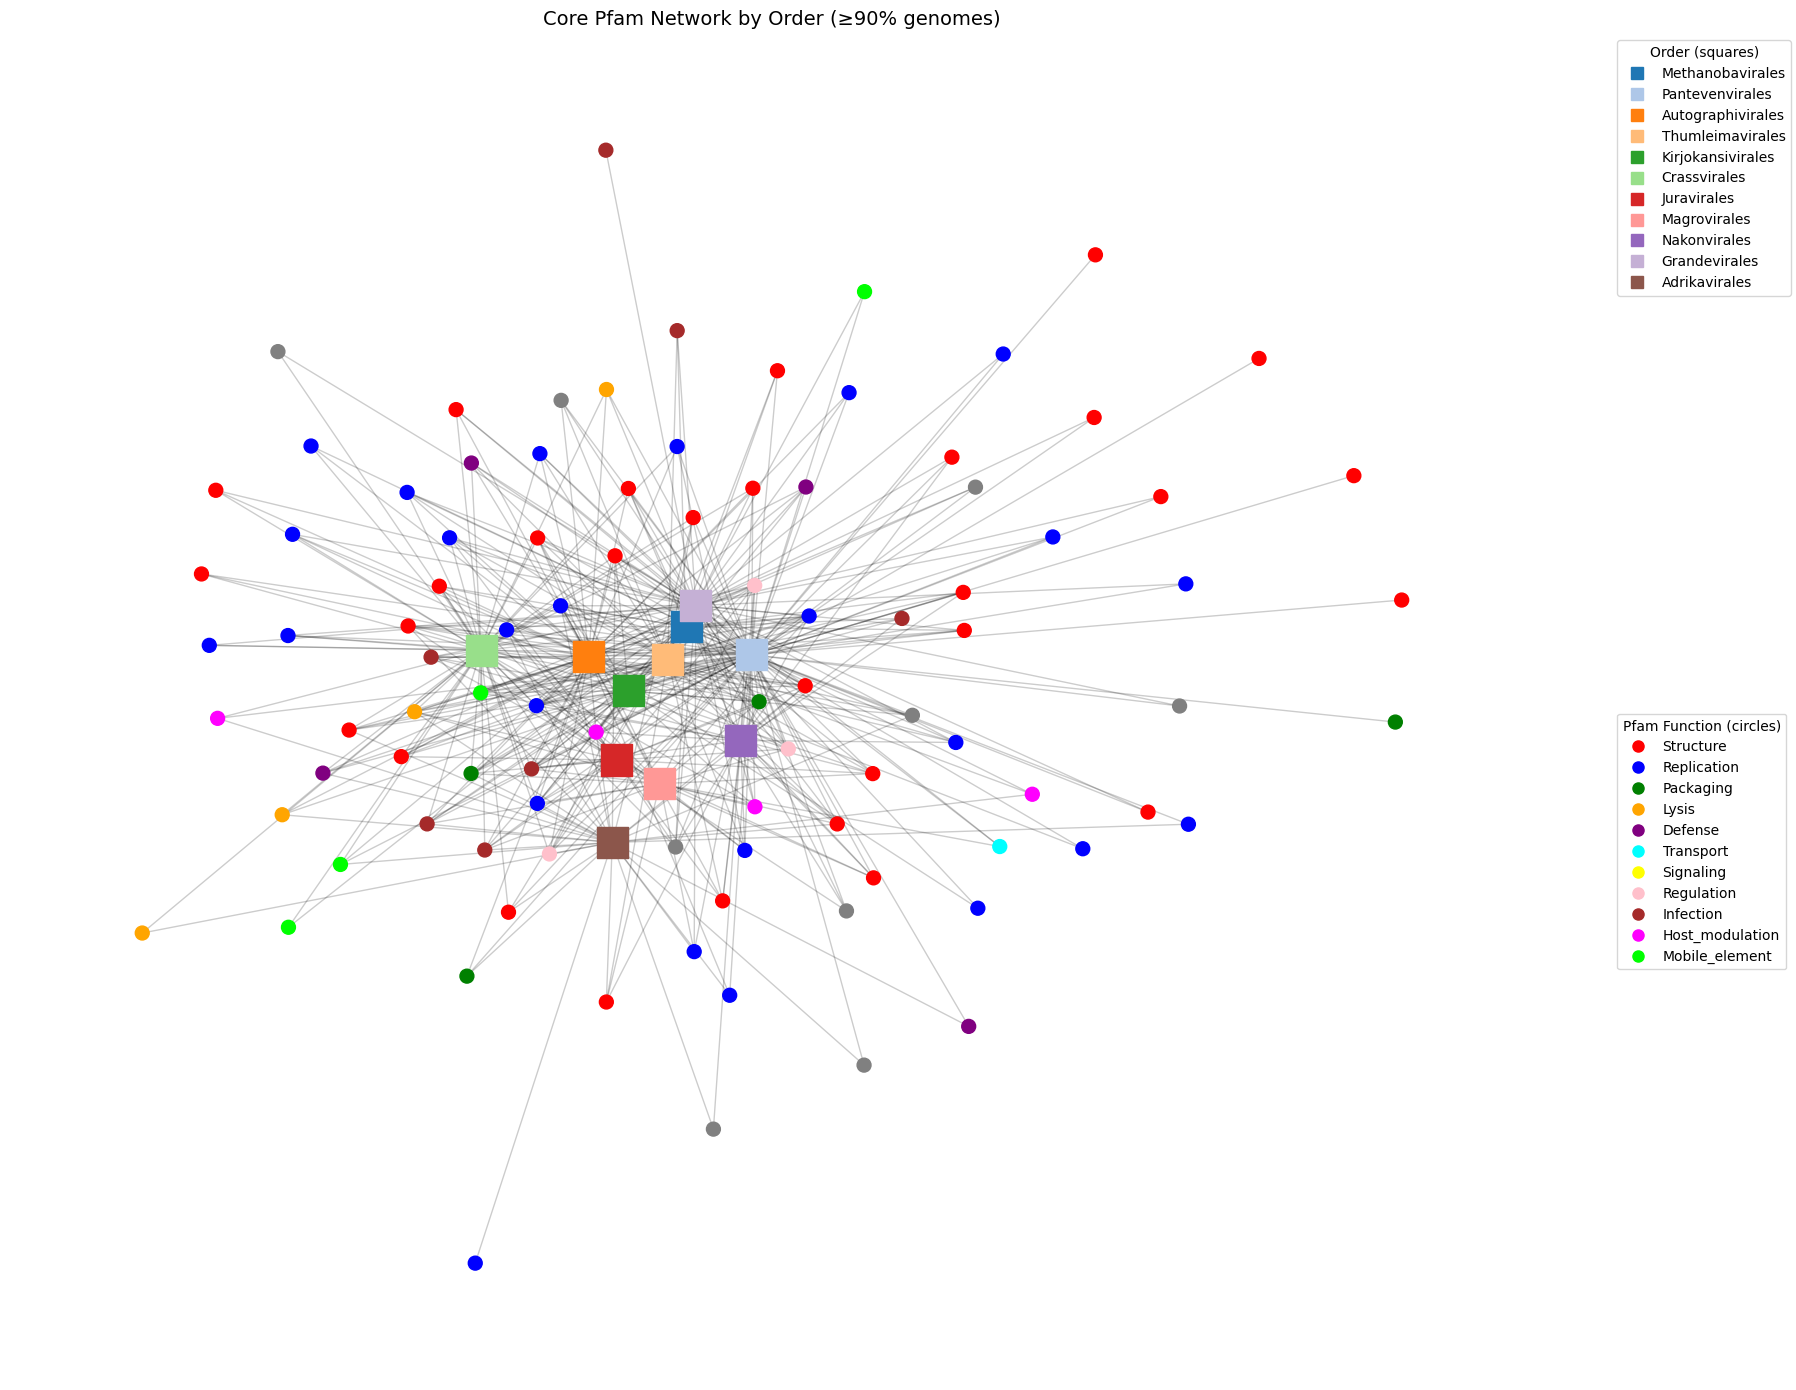

In [32]:
plot_core_pfam_network_collapsed(df, rank='Order', threshold=0.9, highlight_rank='Caudovirales')

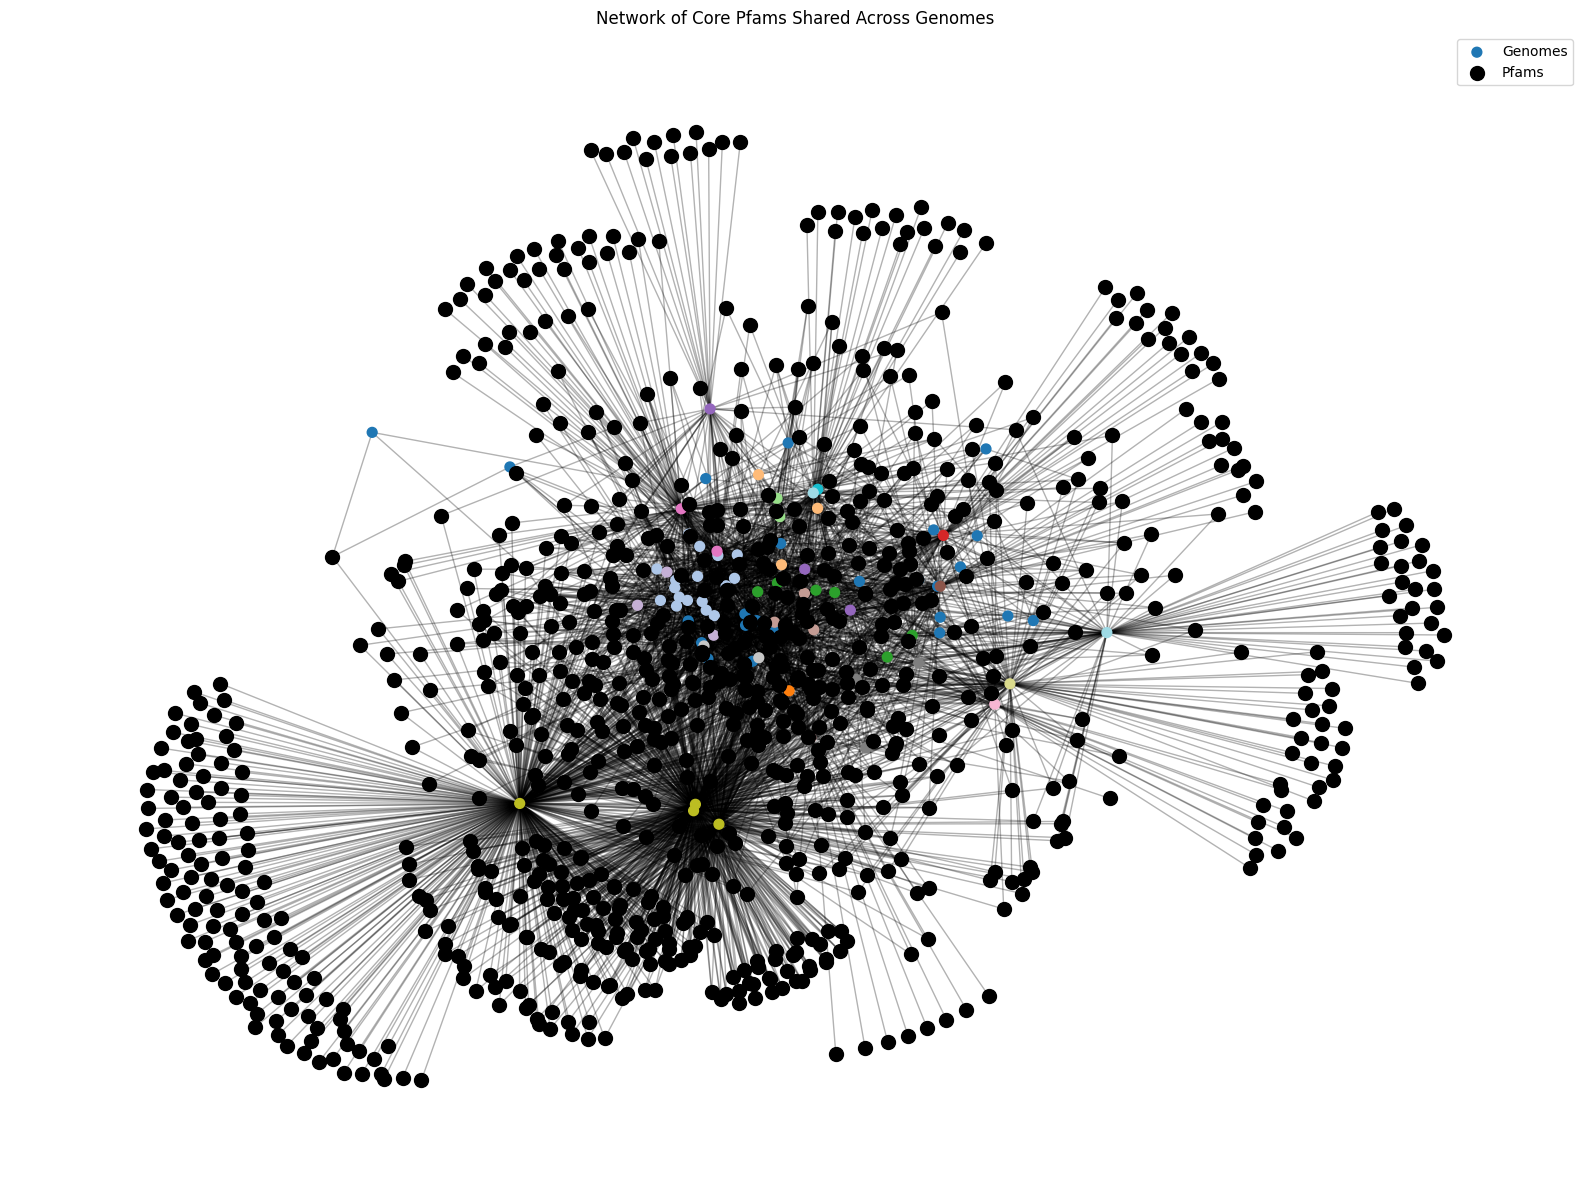

In [111]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Choose core Pfams (e.g. present in ≥80% of genomes in their family)
family_totals = df[['Family', 'genome_accn']].drop_duplicates().groupby('Family').size()
pfam_counts = df.groupby(['Family', 'Pfam'])['genome_accn'].nunique()
pfam_frac = (pfam_counts / family_totals).reset_index()
pfam_frac.columns = ['Family', 'Pfam', 'Fraction']

core_pfams = pfam_frac[pfam_frac['Fraction'] >= 0.8]['Pfam'].unique()

# Step 2: Subset dataframe to just core Pfams
core_df = df[df['Pfam'].isin(core_pfams)]

# Step 3: Build bipartite graph (genome ↔ Pfam)
B = nx.Graph()

# Add genome nodes (with family info as attribute)
for _, row in core_df[['genome_accn', 'Family']].drop_duplicates().iterrows():
    B.add_node(row['genome_accn'], type='genome', family=row['Family'])

# Add Pfam nodes
for pfam in core_pfams:
    B.add_node(pfam, type='pfam')

# Add edges: genome ↔ pfam
for _, row in core_df[['genome_accn', 'Pfam']].drop_duplicates().iterrows():
    B.add_edge(row['genome_accn'], row['Pfam'])

# Step 4: Visualize
# Get positions using bipartite layout or spring layout
pos = nx.spring_layout(B, seed=42)

# Draw nodes by type
genome_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'genome']
pfam_nodes = [n for n, d in B.nodes(data=True) if d['type'] == 'pfam']

# Assign colors by family
families = core_df[['genome_accn', 'Family']].drop_duplicates().set_index('genome_accn')['Family']
family_colors = {fam: i for i, fam in enumerate(families.unique())}
node_colors = [family_colors.get(B.nodes[n].get('family'), 0) for n in genome_nodes]

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(B, pos, nodelist=genome_nodes, node_color=node_colors, node_size=50, cmap='tab20', label='Genomes')
nx.draw_networkx_nodes(B, pos, nodelist=pfam_nodes, node_color='black', node_size=100, label='Pfams')
nx.draw_networkx_edges(B, pos, alpha=0.3)
plt.title("Network of Core Pfams Shared Across Genomes")
plt.axis('off')
plt.tight_layout()
plt.legend()
plt.show()
